# Configuration

In [4]:
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
from pyspark.sql.types import *
import pyspark.sql.functions as f
import datetime
import numpy as np
import pandas as pd
import glob
import time
from datetime import date
import matplotlib.pyplot as plt
import json

# Ex1

In [5]:
a = """*
**
***
****
*****"""
# show_stars = int(input("Input number of rows: "))

def show_stars(rows):
    a = ''
    for i in range(0,rows):
        a += '*'
        print(a)

In [6]:
show_stars(5)

*
**
***
****
*****


# Ex2

In [7]:
states = [0.0]*100

# Gọi xác suất đến được tầng n là: state[n]

# Xác suất đến tầng 0 là: 
states[0] = 1.0

In [8]:
# Giải theo Markov Chain

for i in range(100):
    tmp_states = [0]*100
    for i in range(100):
        tmp_states[i+1 if i < 99 else 99] += states[i]*19/36
        tmp_states[i+2 if i < 98 else 99] += states[i]*1/36
        tmp_states[i+3 if i < 97 else 99] += states[i]*1/36
        tmp_states[i+4 if i < 96 else 99] += states[i]*1/36
        tmp_states[i+5 if i < 95 else 99] += states[i]*1/36
        tmp_states[i+6 if i < 94 else 99] += states[i]*1/36
        tmp_states[i-1 if i > 0 else 0] += states[i]*1/3
    for i in range(100):
        states[i] = tmp_states[i]

In [9]:
# Nếu đến được tầng 60 trở lên sẽ thắng nên xác suất thắng cuộc sẽ là:

sum = 0
for i in range(0, len(states[60:])):
    sum = sum + states[60:][i]
    
print("Xác suất thắng cuộc: ", sum)

Xác suất thắng cuộc:  0.8370191010391311


# Ex3

## Tổng hợp dữ liệu

In [10]:
df_mci = sqlContext.createDataFrame(pd.read_csv("/home/hieunt14/Risk/Hayden/name/yob1880.txt", names=["name","sex", "number"]))\
.withColumn("year", f.lit(1880))
for i in range(1881,2019):
    location_file = "";
    location_file += location_file + ("/home/hieunt14/Risk/Hayden/name/yob" + str(i)+ ".txt");
    df_mci = df_mci.union(sqlContext.createDataFrame(pd.read_csv(location_file, names=["name","sex", "number"])).withColumn("year", f.lit(i)))

In [11]:
df_mci_pd = df_mci.toPandas()

In [12]:
df_mci_pd.head(5)

,name,sex,number,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


## Total births by sex and year

In [13]:
# Tính số lượng trẻ sinh ra theo giới tính và năm 
df_births = df_mci_pd.groupby(["year", "sex"], as_index=False)["number"].sum()

Text(0.5, 1.0, 'Total births by sex and year')

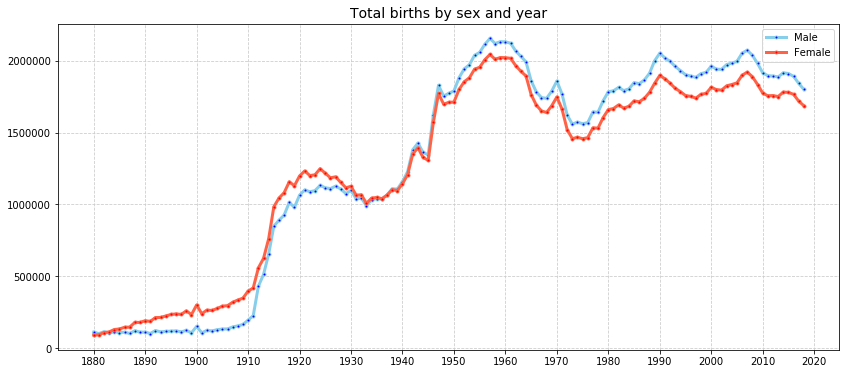

In [14]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')

plt.plot( 'year', 'number', data = df_births[(df_births["sex"] == "M")], marker='o', markerfacecolor='blue',
         markersize=3, color='skyblue', linewidth=3, label= "Male")
plt.plot( 'year', 'number',data = df_births[(df_births["sex"] == "F")], marker='o', markerfacecolor='red',
         markersize=3, color='tomato', linewidth=3, label= "Female")
plt.legend()
plt.title('Total births by sex and year', fontsize = 14)
# plt.xticks(rotation=90)

## Create subset include top 1000 popular names by year

In [15]:
def percentage(group_by):
    number = group_by.number.astype(float)
    group_by['percen'] = number/number.sum()
    return group_by

In [16]:
df_names = df_mci_pd.groupby(['year','sex']).apply(percentage)

In [17]:
def get_top1000(group_by):
    return group_by.sort_index(by='number', ascending=False)[:1000]

In [18]:
df_name_grouped = df_names.groupby(['year','sex'])

In [19]:
df_name_grouped.head(5)

,name,sex,number,year,percen
0,Mary,F,7065,1880,0.077642
1,Anna,F,2604,1880,0.028617
2,Emma,F,2003,1880,0.022012
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
...,...,...,...,...,...
1943042,Liam,M,19837,2018,0.011018
1943043,Noah,M,18267,2018,0.010146
1943044,William,M,14516,2018,0.008063
1943045,James,M,13525,2018,0.007512


In [20]:
df_name_grouped_top_1000 = df_name_grouped.apply(get_top1000)\
.reset_index(drop=True)\
.sort_values(["year", "percen"], ascending = [True, False])\
.reset_index()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

by argument to sort_index is deprecated, please use .sort_values(by=...)



In [21]:
df_top_1000_male = df_name_grouped_top_1000[df_name_grouped_top_1000["sex"] == "M"]

df_top_1000_female = df_name_grouped_top_1000[df_name_grouped_top_1000["sex"] == "F"]

In [22]:
df_top_1000_male.head(6)

,index,name,sex,number,year,percen
0,942,John,M,9655,1880,0.087383
1,943,William,M,9532,1880,0.086270
3,944,James,M,5927,1880,0.053643
4,945,Charles,M,5348,1880,0.048403
5,946,George,M,5126,1880,0.046393
6,947,Frank,M,3242,1880,0.029342


## Total births by names: Philip, Harry, Elizabeth, Marilyn

In [30]:
df_subset_name = df_mci_pd.pivot_table(values = 'number', index='year', columns = 'name', aggfunc="sum")[['John','Harry','Mary','Marilyn']]

In [31]:
df_subset_name.head(5)

name,John,Harry,Mary,Marilyn
year,,,,
1880,9701.0,2158.0,7092.0,NaN
1881,8795.0,2002.0,6948.0,NaN
1882,9597.0,2246.0,8178.0,NaN
1883,8934.0,2116.0,8044.0,NaN
1884,9428.0,2338.0,9253.0,NaN


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdef1ed63c8>,
      dtype=object)

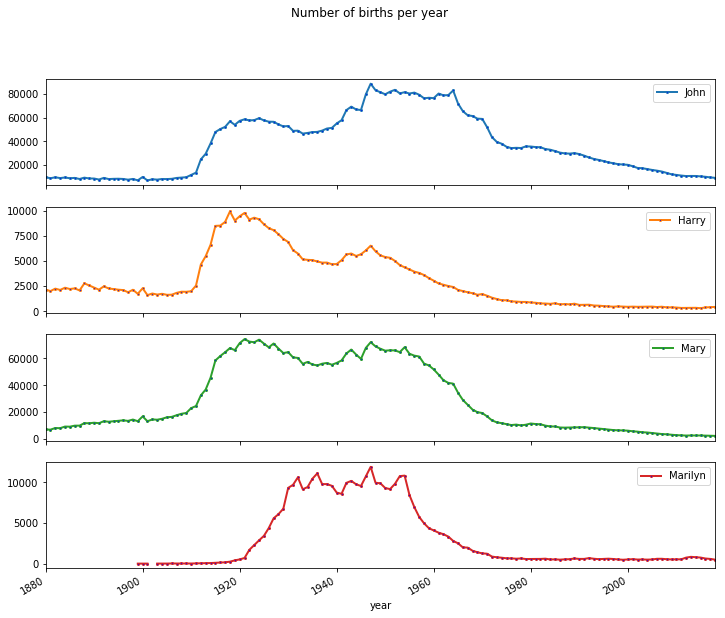

In [32]:
# Vẽ chart
df_subset_name.plot(figsize=(12,10),grid=False, subplots=True, 
                 marker='o', markerfacecolor='blue', markersize=2, linewidth=2, title='Number of births per year')

In [35]:
df_name_compare = df_mci_pd\
.groupby(["year","name"], as_index=False)["number"].sum()

Text(0.5, 1.0, 'Total births by name and year')

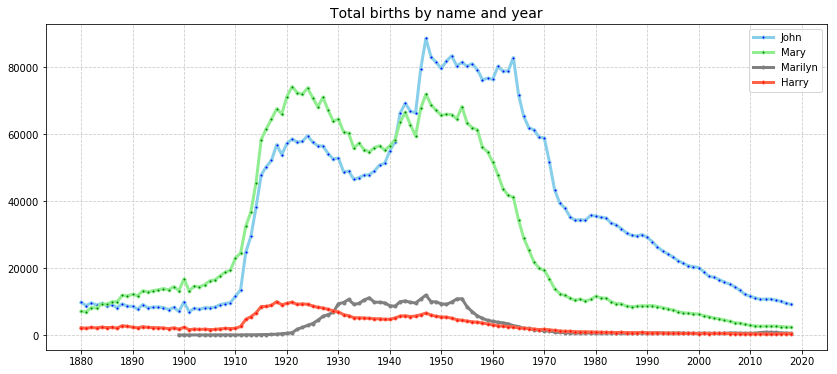

In [37]:
# So sáng số lượng giữa các nhóm tên

fig, ax = plt.subplots(figsize=(14, 6))
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')

plt.plot( 'year', 'number', data = df_name_compare[df_name_compare["name"] == "John"], marker='o', markerfacecolor='blue',
         markersize=3, color='skyblue', linewidth=3, label= "John")
plt.plot( 'year', 'number', data = df_name_compare[df_name_compare["name"] == "Mary"], marker='o', markerfacecolor='green',
         markersize=3, color='lightgreen', linewidth=3, label= "Mary")
plt.plot( 'year', 'number', data = df_name_compare[df_name_compare["name"] == "Marilyn"], marker='o', markerfacecolor='grey',
         markersize=3, color='grey', linewidth=3, label= "Marilyn")
plt.plot( 'year', 'number', data = df_name_compare[df_name_compare["name"] == "Harry"], marker='o', markerfacecolor='red',
         markersize=3, color='tomato', linewidth=3, label= "Harry")
plt.legend()
plt.title('Total births by name and year', fontsize = 14)

In [ ]:
Trong 4 loại tên này thì John và Mary là 2 tên chiếm tỷ trọng nhiều nhất và bùng nổ kéo dài một giai đoạn 1920 -> 1970

## Name diversity

In [38]:
df_name_diversity = df_name_grouped_top_1000.pivot_table(values = 'percen', index='year', columns = 'sex', aggfunc="sum").reset_index()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning:

Second argument 'M' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.



Text(0.5, 1.0, 'Name diversity trend')

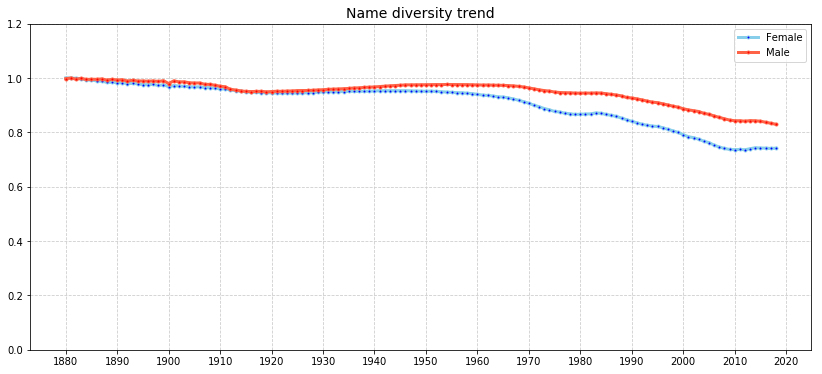

In [39]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.set_ylim(0, 1.2)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')

plt.plot( 'year', 'F', data = df_name_diversity[["year", "F"]], marker='o', markerfacecolor='blue',
         markersize=3, color='skyblue', linewidth=3, label= "Female")
plt.plot( 'year', 'M', data = df_name_diversity[["year", "M"]], marker='o', markerfacecolor='red',
         markersize=3, color='tomato', linewidth=3, label= "Male")
plt.legend()
plt.title('Name diversity trend', fontsize = 14)

In [ ]:
Chọn mốc 1880 đạt 100%, ta thấy có sự giảm dần tỷ trọng đa dạng tên theo giới tính của top 1000 cái tên phổ biến. 
    - Đối với Nữ, có sự giảm nhẹ kể từ năm 1960 và Nam là từ 1970 trở đi. 
    - Từ 1980 cả Nam và Nữ đều giảm dần đều theo thời gian, đến 2018 rơi vào khoảng 82% cho Nam và 75% cho Nữ. Điều này cho thấy càng về sau,
    càng xuất hiện nhiều tên mới cho trẻ em hơn. 

## First letter of name

In [40]:
# Extract first letter
df_first_letter = df_mci_pd[df_mci_pd["year"].isin([1900, 1960, 2018])]
df_first_letter["first_letter"] = df_first_letter["name"].astype(str).str[0]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [41]:
df_first_letter_pivot = df_first_letter\
.pivot_table(values = "number", index = "first_letter", columns = ["sex", "year"], aggfunc = "sum")\
.reindex(columns=[1900,1960,2018], level='year')

In [42]:
df_first_letter_percen = df_first_letter_pivot/df_first_letter_pivot.sum().astype(float)

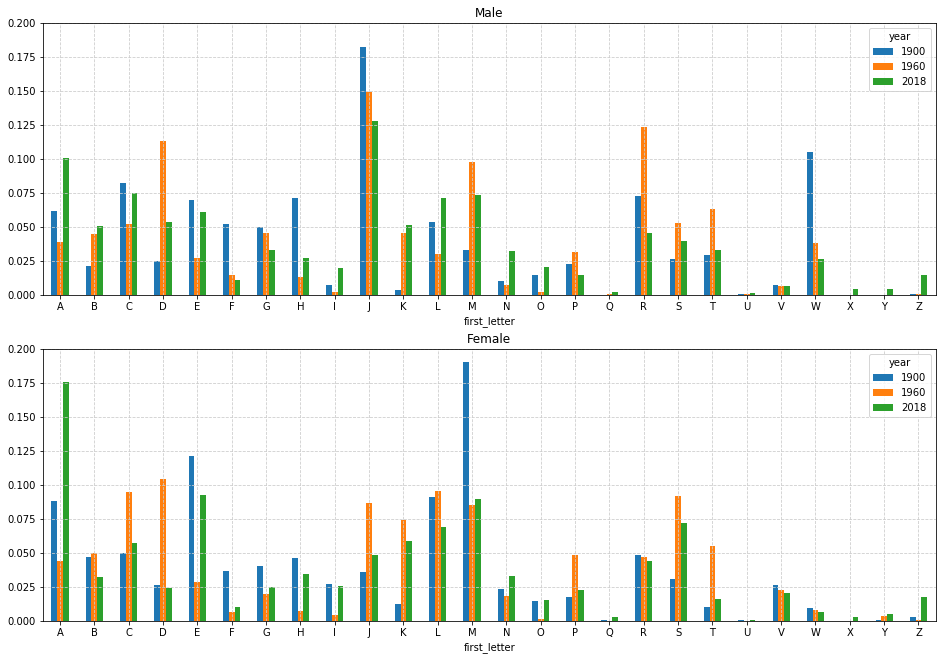

In [43]:
fig, axes = plt.subplots(2, 1, figsize=(16,11))
axes[0].set_ylim(0, 0.2)

df_first_letter_percen['M'].plot(kind='bar', rot=0, ax=axes[0], title='Male')
df_first_letter_percen['F'].plot(kind='bar', rot=0, ax=axes[1], title='Female')

axes[0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1].grid(which='major', color='#CCCCCC', linestyle='--')